In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split,StratifiedKFold
import os
import keras
from keras import backend as K
from keras.utils import Sequence
from PIL import Image
import cv2
import albumentations
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D , MaxPool2D, UpSampling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization, Multiply
from keras.layers import LeakyReLU, Dense, GlobalAveragePooling2D, Lambda, GlobalMaxPooling2D
from keras.layers import ZeroPadding2D, Flatten
from keras.losses import binary_crossentropy
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, add, multiply
from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from classification_models import Classifiers
from tqdm import tqdm_notebook
import keras.callbacks as callbacks
import tensorflow as tf
import seaborn as sns
import shutil

from collections import defaultdict

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [74]:
train_img_dir = './rsnajpg512stage2/stage_2_train_images'
train_mask_dir = './rsnajpg512stage2/stage_2_train.csv'
test_img_dir = './rsnajpg512stage2/stage_2_test_images'
test_sub_dir = './rsnajpg512stage2/stage_2_sample_submission.csv'

epochs = 10
batch_size = 28
swa_nb = epochs-5

lr = 0.001
image_size = (256,256)


model_name = 'Class_base'

(512, 512, 3)


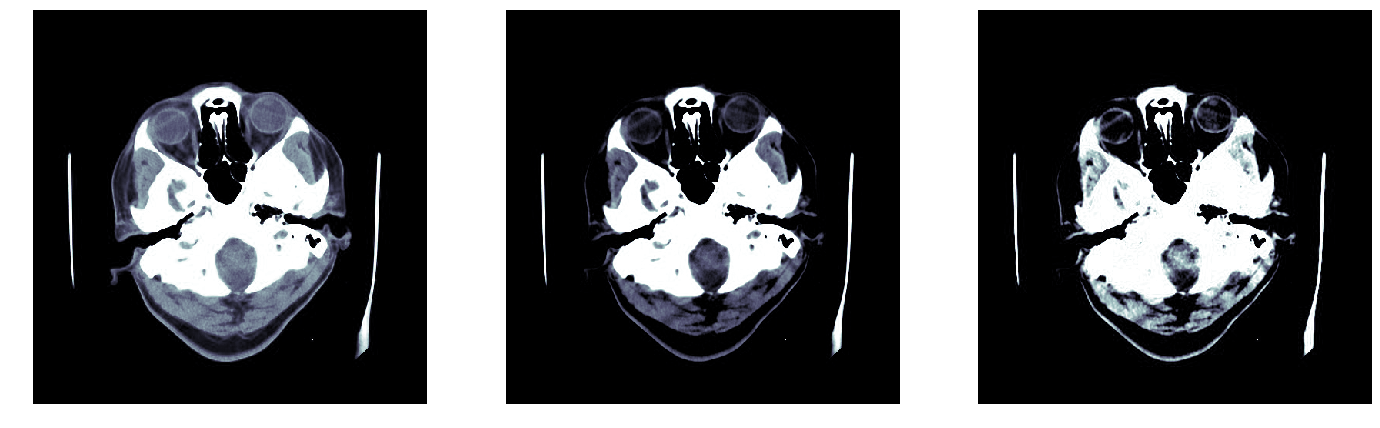

In [3]:
train_dir_image_check = glob.glob(train_img_dir+'/*')[0]
img = Image.open(train_dir_image_check)
img = np.array(img)
plt.figure(figsize=(24,8))
for i in range(3):
    plt.subplot(1,3,i+1), plt.imshow(img[:,:,i],cmap='bone')
    plt.axis('off')

print(np.array(img).shape)

# brain(40,80), subdural(80,200), soft(40,380)

In [5]:
cls_df = pd.read_csv(train_mask_dir)
cls_df.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [6]:
cls_df.iloc[0:6,1].values.tolist()

[0, 0, 0, 0, 0, 0]

the number of images with no defects: 644874
the number of images with defects: 107933


defaultdict(int, {0: 644874, 2: 75859, 4: 6217, 3: 24826, 5: 1008, 6: 23})

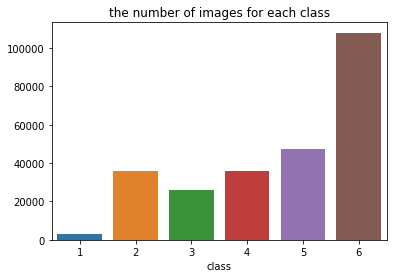

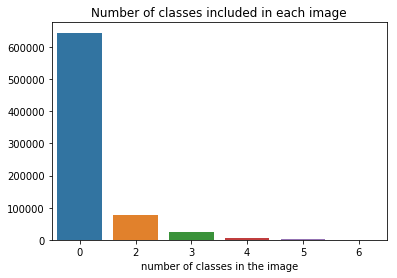

In [7]:
#https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_cls = 0
cls = 0

for col in range(0, len(cls_df), 6):
    img_names = [str(i).split("_")[0] for i in cls_df.iloc[col:col+6, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3] == img_names[4] == img_names[5]):
        raise ValueError
        
    labels = cls_df.iloc[col:col+6, 1]
    check = labels.sum()
    kind_class_dict[check]+=1
    if check == 0:
        no_cls += 1
    else:
        cls += 1

    for idx, label in enumerate(labels.values.tolist()):
        if label == 1:
            class_dict[idx+1] += 1
            
print("the number of images with no defects: {}".format(no_cls))
print("the number of images with defects: {}".format(cls))


fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict


fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

In [8]:
def read_testset(filename = test_sub_dir):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    return df

def read_trainset(filename = train_mask_dir):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    duplicates_to_remove = [
        56340, 56341, 56342, 56343, 56344, 56345, 56346, 56347, 56348, 56349, 56350,
        56351, 1171824, 1171825, 1171826, 1171827, 1171828, 1171829, 1171830, 1171831,
        1171832, 1171833, 1171834, 1171835, 3705306, 3705307, 3705308, 3705309, 3705310,
        3705311, 3705312, 3705313, 3705314, 3705315, 3705316, 3705317, 3842472, 3842473,
        3842474, 3842475, 3842476, 3842477, 3842478, 3842479, 3842480, 3842481, 3842482, 3842483
    ]
    df = df.drop(index = duplicates_to_remove)
    df = df.reset_index(drop = True)    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    return df

# Read Train and Test Datasets
test_df = read_testset()
train_df = read_trainset()

In [9]:
train_df.head(20)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
ID_0000aee4b     0        0                0                0            0   
ID_0000ca2f6     0        0                0                0            0   
ID_0000f1657     0        0                0                0            0   
ID_000178e76     0        0                0                0            0   
ID_00019828f     0        0                0                0            0   
ID_0001dcc25     0        0                0                0            0   
ID_0001de0e8     0        0                0                0            0   
ID_0001f7f62     0        0                0                0            0   
ID_0002003a8     0        0                0                0            0   
ID_0002081b6     1        0                1                0            0   
ID_0002108bd     0        0                0                0            0   
ID_000229f2a     0        0                0                0            0   
ID_000230ed7     0        0                0                0            0   
ID_000259ccf     0        0                0                0            0   
ID_00025ef4b     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
ID_0000aee4b        0  
ID_0000ca2f6        0  
ID_0000f1657        0  
ID_000178e76        0  
ID_00019828f        0  
ID_0001dcc25        0  
ID_0001de0e8        0  
ID_0001f7f62        0  
ID_0002003a8        0  
ID_0002081b6        0  
ID_0002108bd        0  
ID_000229f2a        0  
ID_000230ed7        0  
ID_000259ccf        0  
ID_00025ef4b        0

In [21]:
(train_df.index[0])

'ID_000012eaf'

In [24]:
class Datagen(Sequence):
    def __init__(self, train_dir = train_img_dir, label_df = train_df, augmentation = None,
                 batch_size = batch_size, shuffle = True, image_size = image_size, preprocess = None, subset = 'train'):
        self.train_dir = train_dir
        self.label_df = label_df
        self.augment = augmentation
        self.batch_size = batch_size
        self.shuffle = shuffle            
        self.image_size = image_size
        self.subset = subset
        self.preprocess = preprocess   ## imagenet preprocess
        self.on_epoch_end()

    def __getitem__(self,index):
        # get the indexes
        indexes = self.indexes[(index)*self.batch_size:min((index+1)*self.batch_size,len(self.label_df.index))]

        # list of items
        list_id_items = [self.label_df.index[x] for x in indexes]
        image, label = self._data_generator(list_id_items)

        if self.augment is None:
            if self.subset == 'train': return image, label
            else: return image
        else:
            images = [] 
            for x in image:
                augment_result = self.augment(image = x)
                images.append(augment_result['image'])
            if self.subset == 'train': return np.array(images), label
            else: return np.array(images)
        
    def __len__(self):
        return int(np.ceil(len(self.label_df.index)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.label_df.index))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def _data_generator(self,list_id_items):
        batch_size = len(list_id_items)
        images = np.empty((batch_size, *self.image_size, 3))
        labels = np.empty((batch_size,6))
        for i , data in enumerate(list_id_items):
            # get source image
 
            im = cv2.resize(np.array(Image.open(self.train_dir+'/'+data+'.jpg')),self.image_size)
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

            if self.subset == 'train': 
                label = self.label_df.loc[data].values
                
            if self.preprocess!=None: im = self.preprocess(im)
            images[i,] = im
            labels[i,] = label
            
        return np.uint8(images), labels

C:\Users\a2720\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


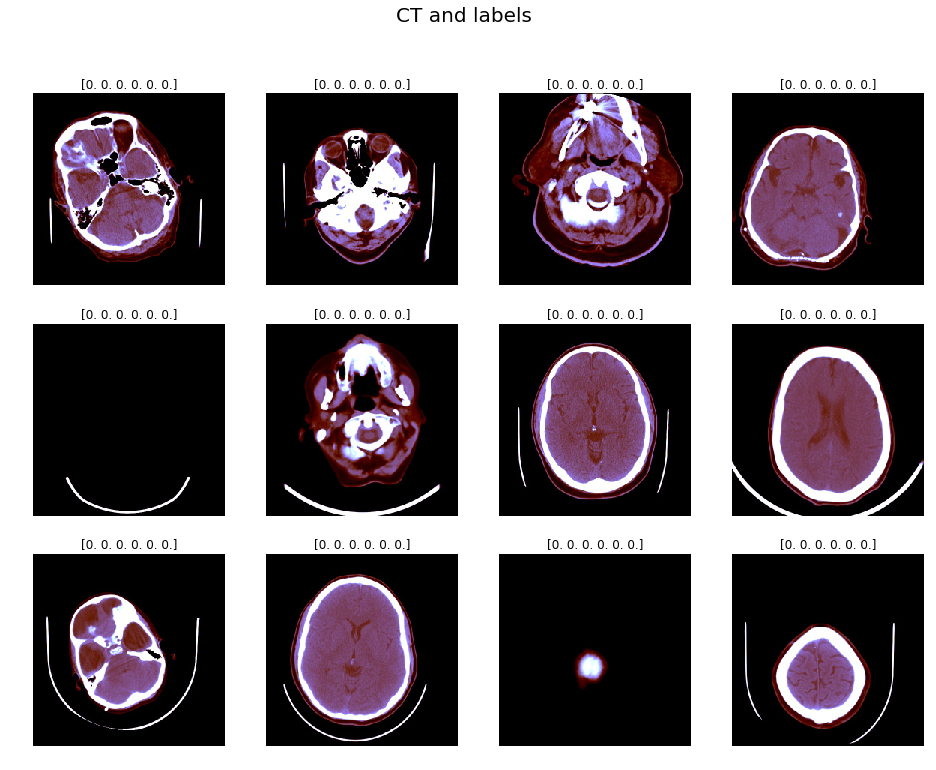

In [54]:
def print_test_data(data_gen , total_image , augmentation = None , shuffle = False):
    Dgen = data_gen(batch_size=total_image, shuffle=shuffle ,augmentation = augmentation)
    images, labels = Dgen.__getitem__(0)
    fig_width = 4
    fig_height = int(total_image/fig_width)
    fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*4,fig_height*4))

    for i, (im , lb) in enumerate(zip(images,labels)):
        ax = axes[int(i/fig_width),i%fig_width]
        ax.imshow(im.squeeze().astype('uint8'))
        ax.title.set_text(lb)
        ax.axis('off')
    plt.suptitle("CT and labels",fontsize=20)
    
print_test_data(Datagen,12,shuffle= False)

In [12]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
AUGMENTATIONS_TRAIN = Compose([    
    HorizontalFlip(),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
    ], p=0.3),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10)],p=1)


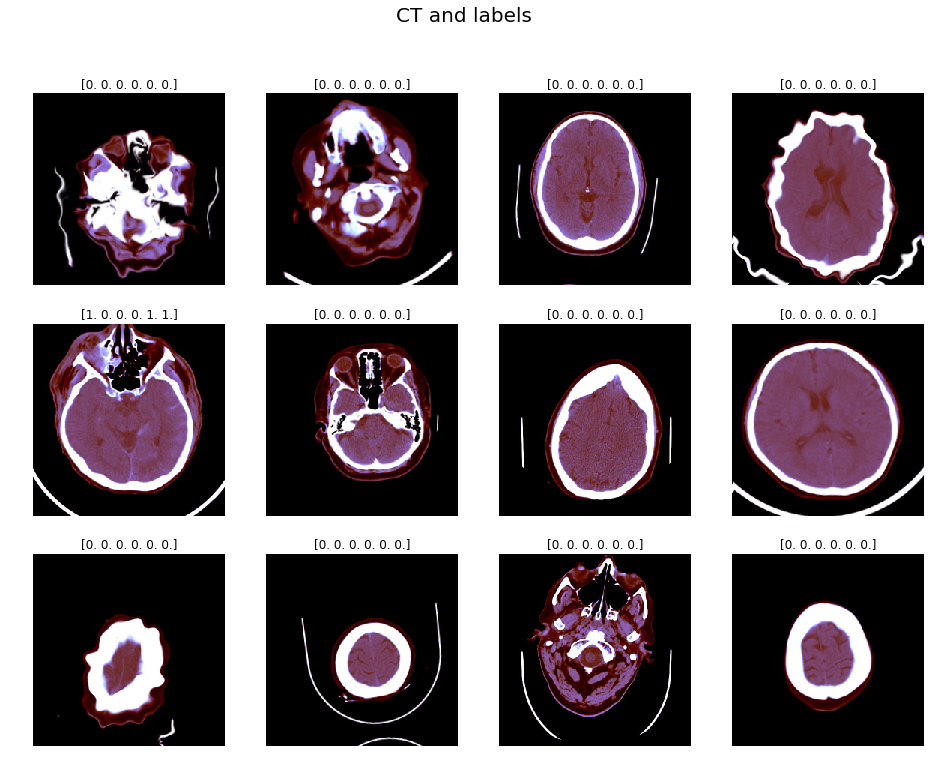

In [13]:
print_test_data(Datagen,12,augmentation = AUGMENTATIONS_TRAIN ,shuffle= False)

In [68]:
from efficientnet import EfficientNetB3

def EfficientModel(input_shape=(*image_size, 3)):
    K.clear_session()
    base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape, pooling = 'avg')
    input_L = base.input
    output_L = Dense(6, activation = 'sigmoid')(base.output)

    model = Model(input_L, output_L)
    model.name = 'UEfficientNet'

    return model

In [69]:
model = EfficientModel()
model.summary()

#model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[dice_coef])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 40) 160         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 128, 128, 40) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

activation_3 (Activation)       (None, 1, 1, 144)    0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
multiply_3 (Multiply)           (None, 64, 64, 144)  0           activation_3[0][0]               
                                                                 swish_7[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 32)   4608        multiply_3[0][0]                 
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 64, 64, 32)   128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 64, 64, 192)  6144        batch_normalization_8[0][0]      
__________

__________________________________________________________________________________________________
depthwise_conv2d_6 (DepthwiseCo (None, 32, 32, 192)  4800        swish_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 32, 32, 192)  768         depthwise_conv2d_6[0][0]         
__________________________________________________________________________________________________
swish_16 (Swish)                (None, 32, 32, 192)  0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 1, 1, 192)    0           swish_16[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 1, 1, 8)      1544        lambda_6[0][0]                   
__________

__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 48)   13824       multiply_8[0][0]                 
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 32, 32, 48)   192         conv2d_31[0][0]                  
__________________________________________________________________________________________________
drop_connect_5 (DropConnect)    (None, 32, 32, 48)   0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
add_5 (Add)                     (None, 32, 32, 48)   0           drop_connect_5[0][0]             
                                                                 add_4[0][0]                      
__________________________________________________________________________________________________
conv2d_32 

__________________________________________________________________________________________________
swish_31 (Swish)                (None, 16, 16, 576)  0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 1, 1, 576)    0           swish_31[0][0]                   
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 1, 1, 24)     13848       lambda_11[0][0]                  
__________________________________________________________________________________________________
swish_32 (Swish)                (None, 1, 1, 24)     0           conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 1, 1, 576)    14400       swish_32[0][0]                   
__________

                                                                 swish_37[0][0]                   
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 16, 16, 96)   55296       multiply_13[0][0]                
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 16, 16, 96)   384         conv2d_51[0][0]                  
__________________________________________________________________________________________________
drop_connect_9 (DropConnect)    (None, 16, 16, 96)   0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
add_9 (Add)                     (None, 16, 16, 96)   0           drop_connect_9[0][0]             
                                                                 add_8[0][0]                      
__________

batch_normalization_46 (BatchNo (None, 16, 16, 816)  3264        depthwise_conv2d_16[0][0]        
__________________________________________________________________________________________________
swish_46 (Swish)                (None, 16, 16, 816)  0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 1, 1, 816)    0           swish_46[0][0]                   
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 1, 1, 34)     27778       lambda_16[0][0]                  
__________________________________________________________________________________________________
swish_47 (Swish)                (None, 1, 1, 34)     0           conv2d_61[0][0]                  
__________________________________________________________________________________________________
conv2d_62 

multiply_18 (Multiply)          (None, 16, 16, 816)  0           activation_18[0][0]              
                                                                 swish_52[0][0]                   
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 16, 16, 136)  110976      multiply_18[0][0]                
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 16, 16, 136)  544         conv2d_71[0][0]                  
__________________________________________________________________________________________________
drop_connect_13 (DropConnect)   (None, 16, 16, 136)  0           batch_normalization_53[0][0]     
__________________________________________________________________________________________________
add_13 (Add)                    (None, 16, 16, 136)  0           drop_connect_13[0][0]            
          

__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 8, 8, 1392)   5568        depthwise_conv2d_21[0][0]        
__________________________________________________________________________________________________
swish_61 (Swish)                (None, 8, 8, 1392)   0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 1, 1, 1392)   0           swish_61[0][0]                   
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 1, 1, 58)     80794       lambda_21[0][0]                  
__________________________________________________________________________________________________
swish_62 (Swish)                (None, 1, 1, 58)     0           conv2d_81[0][0]                  
__________

__________________________________________________________________________________________________
multiply_23 (Multiply)          (None, 8, 8, 1392)   0           activation_23[0][0]              
                                                                 swish_67[0][0]                   
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 8, 8, 232)    322944      multiply_23[0][0]                
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 8, 8, 232)    928         conv2d_91[0][0]                  
__________________________________________________________________________________________________
drop_connect_17 (DropConnect)   (None, 8, 8, 232)    0           batch_normalization_68[0][0]     
__________________________________________________________________________________________________
add_17 (Ad

depthwise_conv2d_26 (DepthwiseC (None, 8, 8, 2304)   20736       swish_75[0][0]                   
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 8, 8, 2304)   9216        depthwise_conv2d_26[0][0]        
__________________________________________________________________________________________________
swish_76 (Swish)                (None, 8, 8, 2304)   0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
lambda_26 (Lambda)              (None, 1, 1, 2304)   0           swish_76[0][0]                   
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 1, 1, 96)     221280      lambda_26[0][0]                  
__________________________________________________________________________________________________
swish_77 (

In [41]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save(self.filepath)
        print('Final stochastic averaged model saved to file.')

In [42]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.001, monitors = 'val_acc'):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
        self.monitors = monitors

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint(model_name+'{}.h5'.format(n_fold),monitor=self.monitors, 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [63]:
def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

In [45]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

total_fold = 5

mskf = MultilabelStratifiedKFold(n_splits=total_fold, random_state=0)

X = train_df.index
Y = train_df.Label.values

In [ ]:
train_history=[]

for n_fold, (train_index, test_index) in enumerate(mskf.split(X, Y)):
    
    X_train, X_test = X[train_index], X[test_index]
    
    model = EfficientModel()
    model.compile(loss=weighted_log_loss, optimizer='adam', metrics=['acc'])
    
    train_generator = Datagen(batch_size=batch_size, label_df = train_df.loc[X_train],
                              shuffle=True, augmentation = AUGMENTATIONS_TRAIN)
    
    val_generator = Datagen(batch_size=batch_size, label_df = train_df.loc[X_test],
                            shuffle=False, augmentation = None)
    
    cb = [callbacks.ModelCheckpoint(model_name+'{}.h5'.format(n_fold) ,monitor='val_acc', 
                                   mode = 'max', save_best_only=True, verbose=1)]
    
    history = model.fit_generator(generator=train_generator,
                                  validation_data=val_generator,  
                                  epochs=epochs,verbose=1,
                                  callbacks=cb)
    
    train_history.append(history)

Epoch 1/10


In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['weighted_log_loss'][1:])
plt.plot(history.history['val_weighted_log_loss'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model loss')

plt.subplot(1,2,2)
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
#gc.collect()

In [ ]:
test_df.iloc[:, :] = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])
test_df = test_df.stack().reset_index()
test_df.insert(loc = 0, column = 'ID', value = test_df['Image'].astype(str) + "_" + test_df['Diagnosis'])
test_df = test_df.drop(["Image", "Diagnosis"], axis=1)
test_df.to_csv('submission.csv', index = False)
print(test_df.head(12))
from IPython.display import FileLink, FileLinks
FileLink('submission.csv')